<a href="https://colab.research.google.com/github/sakibchowdhury131/GAN/blob/main/GAN_FACE_GENERATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import keras 
from keras.models import Sequential, Model
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Input
from keras.optimizers import RMSprop
from keras.utils import plot_model

from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [26]:
img_h = 256
img_w = 128

In [28]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/GAN/sakibFaceDataset'
images = os.listdir(dataset_path)
dataset = np.empty((len(images), img_h, img_w, 3))


for i in range (len(images)):
  x = cv2.imread(dataset_path + '/' + images[i])
  x = x / 255
  x = resize(x, (img_h, img_w, 3), anti_aliasing = True)
  dataset[i] = x
  

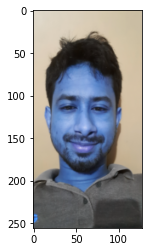

In [29]:
plt.imshow (dataset[10, :, :, :])



In [35]:
dataset.shape

(52, 256, 128, 3)

In [37]:
def discriminator_builder(width = 64, p = 0.4):
  #define the inputs
  inputs = Input((img_h, img_w, 3))
 
  #convolution layers
  conv1 = Conv2D(width*1, 5, strides=2, padding= 'same', activation= 'relu')(inputs)
  conv1 = Dropout(p)(conv1)
  
  conv2 = Conv2D(width*2, 5, strides=2, padding= 'same', activation= 'relu')(conv1)
  conv2 = Dropout(p)(conv2)
  
  conv3 = Conv2D(width*4, 5, strides=2, padding= 'same', activation= 'relu')(conv2)
  conv3 = Dropout(p)(conv3)
 
  conv4 = Conv2D(width*8, 5, strides=1, padding= 'same', activation= 'relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))
 
  #output layer
  output = Dense(1, activation= 'sigmoid')(conv4)
 
  #model definition
  model = Model(inputs = inputs, outputs = output)
  model.summary()
  
 
 
  return model

In [38]:
discriminator = discriminator_builder()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 128, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 64, 64)       4864      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 64, 64)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 32, 128)       204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 16, 256)       819456    
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 16, 256)       0   

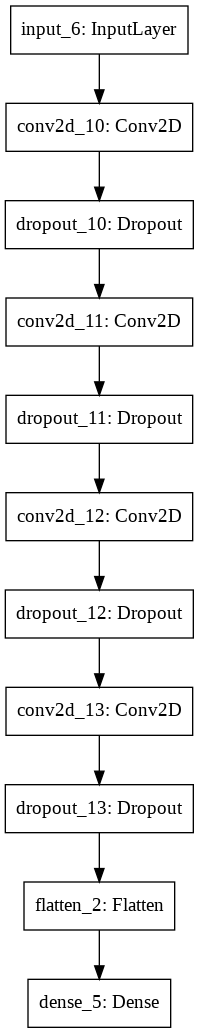

In [39]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer= RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                      metrics=['accuracy'])
plot_model(discriminator)

In [40]:
def generator_builder(z_dim = 100, width=64, p=0.4):
  #define the inputs
  inputs = Input((z_dim,))
 
  #first dense layer:
  dense1 = Dense((img_w/4)*(img_h/4)*64)(inputs)
  dense1 = BatchNormalization(momentum=0.9)(dense1)
  dense1 = Activation(activation = 'relu')(dense1)
  dense1 = Reshape((int(img_h/4), int(img_w/4), 64))(dense1)
  dense1 = Dropout(p)(dense1)
 
  #deconvolution layers
  conv1 = UpSampling2D()(dense1)
  conv1 = Conv2DTranspose(int(width/2), kernel_size = 5, padding = 'same', activation=None)(conv1)
  conv1 = BatchNormalization(momentum= 0.9)(conv1)
  conv1 = Activation(activation = 'relu')(conv1)
 
  conv2 = UpSampling2D()(conv1)
  conv2 = Conv2DTranspose(int(width/4), kernel_size = 5, padding = 'same', activation=None)(conv2)
  conv2 = BatchNormalization(momentum= 0.9)(conv2)
  conv2 = Activation(activation = 'relu')(conv2)
 
  conv3 = Conv2DTranspose(int(width/8), kernel_size = 5, padding = 'same', activation=None)(conv2)
  conv3 = BatchNormalization(momentum= 0.9)(conv3)
  conv3 = Activation(activation = 'relu')(conv3)
 
  #output layer
  output = Conv2D(3, kernel_size = 5, padding = 'same', activation = 'sigmoid')(conv3)
 
  #defining model 
  model = Model(inputs = inputs, outputs = output)
  model.summary()
  plot_model(model)
  return model

In [41]:
generator = generator_builder()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
batch_normalization_9 (Batch (None, 131072)            524288    
_________________________________________________________________
activation_9 (Activation)    (None, 131072)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 64, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 32, 64)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 64, 64)       0   

In [42]:
def adversarial_builder(z_dim = 100):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
 
  model.compile(loss = 'binary_crossentropy',
                optimizer = RMSprop(lr = 0.0004, decay = 3e-8, clipvalue = 1.0),
                metrics = ['accuracy'])
  
  model.summary()
  plot_model(model)
 
  return model

In [43]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 256, 128, 3)       13830643  
_________________________________________________________________
model_4 (Functional)         (None, 1)                 4568705   
Total params: 18,399,348
Trainable params: 18,137,092
Non-trainable params: 262,256
_________________________________________________________________


In [45]:
def make_trainable(net, val):
  net.trainable = val
  for l in net.layers:
    l.trainable = val

In [52]:

def train(epochs=40000,batch=4):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(dataset[np.random.choice(dataset.shape[0],batch,replace=False)],(batch,img_h,img_w,3))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0])
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 0.807399, acc: 0.788076]  [A loss: 2.286090, acc: 0.210421]


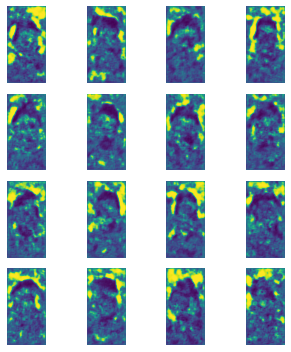

500
600
700
800
900
Epoch #1000
999: [D loss: 0.635701, acc: 0.789289]  [A loss: 2.513926, acc: 0.134885]


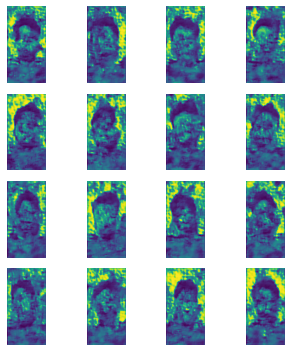

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.530649, acc: 0.817628]  [A loss: 2.702511, acc: 0.100567]


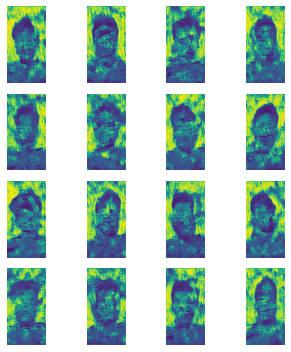

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.463672, acc: 0.841171]  [A loss: 2.872673, acc: 0.080415]


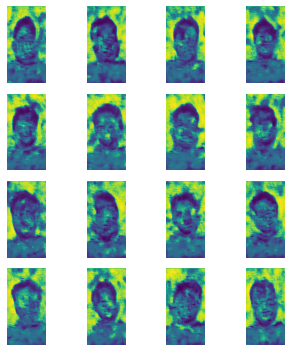

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.408346, acc: 0.860094]  [A loss: 3.012847, acc: 0.065326]


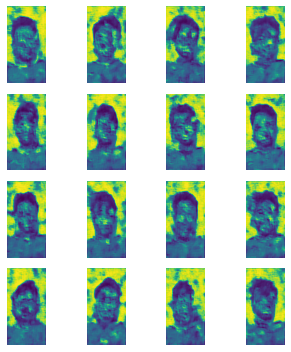

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.375987, acc: 0.872124]  [A loss: 3.086067, acc: 0.056602]


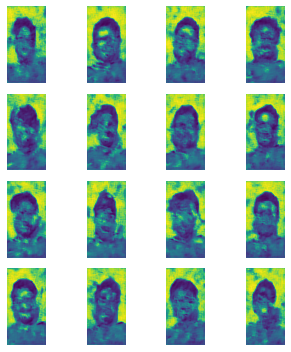

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.355666, acc: 0.879180]  [A loss: 3.120106, acc: 0.050800]


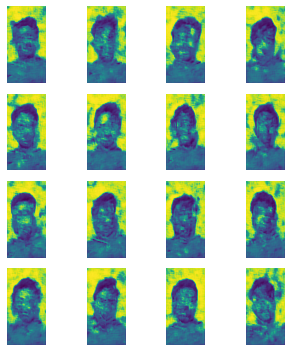

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.340509, acc: 0.884284]  [A loss: 3.176949, acc: 0.046387]


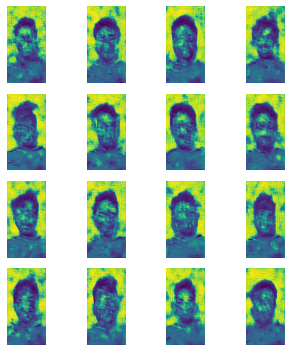

4000


In [ ]:
a_metrics_complete, d_metrics = train(epochs = 40000)